## 코사인 유사도 예시

문서1 : 저는 사과 좋아요 \
문서2 : 저는 바나나 좋아요  \
문서3 : 저는 바나나 좋아요 저는 바나나 좋아요 

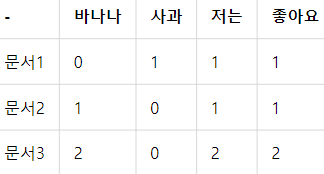


In [5]:
from numpy import dot
from numpy.linalg import norm
import numpy as np

def cos_sim(A, B):
    return dot(A, B) / (norm(A)*norm(B))

In [6]:
doc1 = np.array([0,1,1,1])
doc2 = np.array([1,0,1,1])
doc3 = np.array([2,0,2,2])

BoW(단어의 순서를 고려하지 않고 출현 빈도를 나타내는 텍스트 데이터 수치화 방법)를 만들었다. 이제 각 문서에 대한 코사인 유사도를 계산한다.

In [7]:
print(cos_sim(doc1, doc2))
print(cos_sim(doc1, doc3))
print(cos_sim(doc2, doc3))

0.6666666666666667
0.6666666666666667
1.0000000000000002


문서 2,3의 코사인 유사도가 1이 나온다. BoW를 봐도 문서3은 문서2에서 모든 단어의 빈도수가 1씩 증가했다. 다시말해 모든 단어의 빈도수가 동일하게 증가하는 경우에는 코사인 유사도 값이 1이라는 것이다. 

 코사인 유사도를 사용하지 않고, 문서 A에 대해 모든 문서와의 유사도를 구한다고 가정했을 때 다른 문서들과 문서 B나 거의 동일한 패턴을 가지는 문서임에도 문서 B가 단순히 다른 문서들보다 원문 길이가 길어서 단어의 빈도수가 높게 나올 수 있다. 하지만 코사인 유사도는 유사도를 구할 때, 벡터의 크기가 아니라 벡터의 패턴에 초점을 두기에 문서의 길이가 달라도 비교적 공정한 비교를 하게끔 해준다.

## 유사도를 이용한 추천 시스템 구현하기

dataset의 title, overview컬럼을 활용해 좋아하는 영화를 입력하면, 해당 영화의 줄거리와 줄거리가 유사한 영화를 찾아서 추천하는 시스템을 만든다.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [2]:
data = pd.read_csv(r'D:\다운로드\dataset\movie_rec\movies_metadata.csv', low_memory=False)
data.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [3]:
data = data.head(20000)

In [4]:
data['overview'].isnull().sum()

135

In [5]:
data.overview = data.overview.fillna('')

In [6]:
data['overview'].isnull().sum()

0

In [7]:
data['overview']

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
19995    Dissidents in a French colony attack a police ...
19996    A young mother Nina and her son Enzo find them...
19997    An in-depth analysis of the relationship betwe...
19998    Follows the life and work of animator Lotte Re...
19999    An in-depth look at the genesis, production, a...
Name: overview, Length: 20000, dtype: object

In [8]:
tfidf = TfidfVectorizer(stop_words='english')

tfidf_matrix = tfidf.fit_transform(data.overview)

In [15]:
tfidf_matrix.shape

(20000, 47487)

overview 컬럼에 대해 tf-idf를 수행했다. 20,000개의 영화를 표현하기 위해 총 47,287개의 단어가 사용되었음을 보여준다. 이제 코사인 유사도를 사용해 문서의 유사도를 구한다.

In [16]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [17]:
indices = pd.Series(data.index, index=data.title).drop_duplicates()
print(indices.head())

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64


이 테이블에서 영화의 타이틀을 입력하면 인덱스를 리턴한다.

In [18]:
idx = indices['Father of the Bride Part II']
print(idx)

4


In [19]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    # 선택한 영화의 타이틀로부터 인덱스 받아오기
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # 모든 영화에 대해서 해당 영화와의 유사도를 구한다.
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # 유사도에 따라 영화들을 정렬한다.
    sim_scores = sim_scores[1:11]
    
    # 가장 유사한 10개의 영화 인덱스를 받아온다.
    movie_indices = [i[0] for i in sim_scores]
    
    # 받아온걸 리턴
    return data['title'].iloc[movie_indices]

In [20]:
get_recommendations('The Dark Knight Rises')

12481                            The Dark Knight
150                               Batman Forever
1328                              Batman Returns
15511                 Batman: Under the Red Hood
585                                       Batman
9230          Batman Beyond: Return of the Joker
18035                           Batman: Year One
19792    Batman: The Dark Knight Returns, Part 1
3095                Batman: Mask of the Phantasm
10122                              Batman Begins
Name: title, dtype: object